# 手書き数字認識問題を解く
- 使用するデータはMNIST。
- 畳み込み層２層＋全結合層２層のニューラルネットを使って、手書き数字認識をする。
- 畳み込み層のあるニューラルネットを畳み込みニューラルネット（CNN; convolutional neural networks）と呼ぶ。

# データ読み込み&ニューラルネット用に変換
- CNNを使う場合は一行のベクトルに変換する必要はない。
    - MNISTは28x28ピクセルなので、28x28x1の行列にしておく。最後の１は色の分で、MNISTは白黒なので１チャンネル。
    - もしCIFAR-10などのカラー画像のデータを使うなら、最後の１は３にしておく（RGBで３チャンネル）。

In [1]:
import numpy as np

f = np.load('mnist.npz')
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']

# 28✖️28ピクセルの画像を784次元ベクトルに変換　＆　[0,1]に正規化
X_TRAIN = np.reshape(x_train, (60000, 28, 28, 1)) / 255.
X_TEST = np.reshape(x_test, (10000, 28, 28, 1)) / 255.

# one-hotベクトルに変換
Y_TRAIN = np.eye(10)[y_train]
Y_TEST = np.eye(10)[y_test]

# Kerasを使ってCNNを組む

- 中間層の出力にかける活性化関数はReLU (Rectified Linear Unit)にする。
- 畳み込み層(Conv2D)から全結合層(Dense)に移るときは、Flattenを使って一行のベクトルに平坦化する。
- いくつかConv2Dを通してからDenseを2回だけ掛けるのが多かった（~2015年あたりまで）。

In [2]:
from keras.layers import Input, Conv2D, Flatten, Dense

x = Input(shape=(28,28,1))
h = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(x)
h = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(h)
h = Flatten()(h)
h = Dense(32, activation='relu')(h)
h = Dense(32, activation='relu')(h)
y = Dense(10, activation='softmax')(h)

Using TensorFlow backend.


In [3]:
from keras.models import Model

cnn = Model(inputs=x, outputs=y)

In [4]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                401440    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total para

## モデル構成を可視化
- graphvizとpydotが必要。
- condaを使ったインストール方法は、  
(python2)  
`conda install graphviz pydot`   
(python3)  
`conda install graphviz pydotplus` 

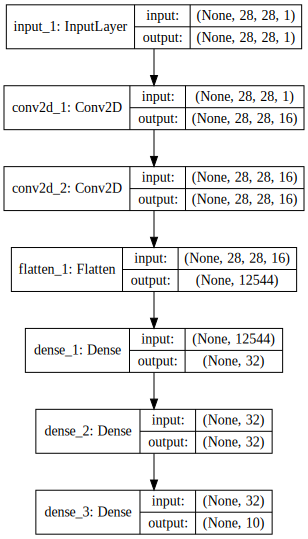

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
cnn.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc'],
)

# 訓練

In [7]:
hist = cnn.fit(
    x = X_TRAIN,
    y = Y_TRAIN,
    epochs=5,
    validation_split=0.1,
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 69s - loss: 0.1859 - acc: 0.9435 - val_loss: 0.0766 - val_acc: 0.9798
Epoch 2/5
54000/54000 [==============================] - 72s - loss: 0.0650 - acc: 0.9799 - val_loss: 0.0582 - val_acc: 0.9835
Epoch 3/5
54000/54000 [==============================] - 68s - loss: 0.0417 - acc: 0.9868 - val_loss: 0.0739 - val_acc: 0.9817
Epoch 4/5
54000/54000 [==============================] - 69s - loss: 0.0313 - acc: 0.9897 - val_loss: 0.0536 - val_acc: 0.9855
Epoch 5/5
54000/54000 [==============================] - 69s - loss: 0.0226 - acc: 0.9925 - val_loss: 0.0566 - val_acc: 0.9863


# 訓練結果の確認

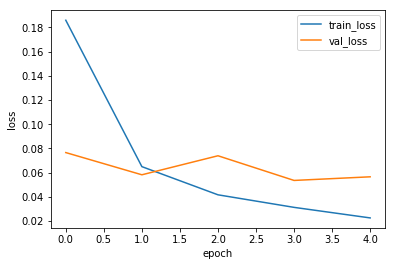

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.epoch, hist.history['loss'], label='train_loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

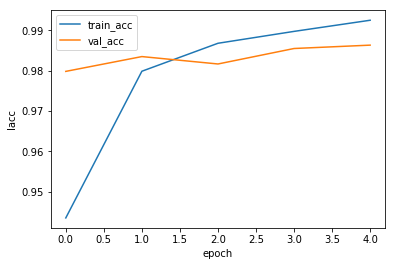

In [9]:
plt.plot(hist.epoch, hist.history['acc'], label='train_acc')
plt.plot(hist.epoch, hist.history['val_acc'], label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('lacc')

In [10]:
cnn.evaluate(x=X_TEST, y=Y_TEST)

 9952/10000 [============================>.] - ETA: 0s

[0.052139067953737683, 0.98419999999999996]

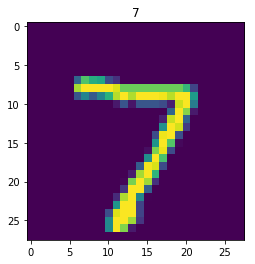

In [11]:
pred = cnn.predict(X_TEST).argmax(axis=1)

plt.imshow(x_test[0])
plt.title(str(pred[0]))